# Infer the model from weights

In [1]:
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler



# Set the seed for reproducibility
seed = 42
cudnn.benchmark = False
cudnn.deterministic = True

random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [2]:
from factory.trainer import Trainer
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

c:\Users\yanni\anaconda3\envs\last\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the trained model

In [3]:
if torch.cuda.is_available():
    model = torch.jit.load(os.path.join("best_models", "scripted_model.pt"), map_location=torch.device("cuda"))
else:
    model = torch.jit.load(os.path.join("best_models", "scripted_model.pt"), map_location=torch.device("cpu"))

## Load the dataset

In [4]:
data = pd.read_csv('./data/dataset.csv', sep=',')
# remove nan values
data = data.dropna()
# shuffle the data for the splitting
data = data.sample(frac=1)

list_of_classes = sorted(data['Class'].unique())
classes_to_idx = {list_of_classes[i]: i for i in range(len(list_of_classes))}
nb_classes = len(list_of_classes)
nb_rows = data.shape[0]
train_split = 0.8
val_split = 0.0

train_data = data.iloc[:int(nb_rows*train_split), :]
val_data = data.iloc[int(nb_rows*train_split):int(nb_rows*(train_split+val_split)), :]
test_data = data.iloc[int(nb_rows*(train_split+val_split)):, :]




## Scaling

In [5]:
x_train = train_data.drop(columns=['Class']).to_numpy()
y_train = [ classes_to_idx[classe] for classe in train_data['Class'].to_list() ]
x_val = val_data.drop(columns=['Class']).to_numpy()
y_val = [ classes_to_idx[classe] for classe in val_data['Class'].to_list() ]
x_test = test_data.drop(columns=['Class']).to_numpy()
y_test = [ classes_to_idx[classe] for classe in test_data['Class'].to_list() ]

x_train_scaled = None
x_val_scaled = None
x_test_scaled = None

config = {  'dataset': {
                'normalize': True,
                'normalize_type': 'scale',
            }
        }

# Apply the transformations to the data before fitting the selected model
if config['dataset']['normalize']:
    # Normalize the data
    # here we do not normalize
    if config['dataset']['normalize_type'] == 'scale':
        # Scale the data
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        if len(x_val) > 0:
            x_val_scaled = scaler.transform(x_val)
        x_test_scaled = scaler.transform(x_test)

# Perform prediction on the loaded model

In [6]:
y_pred = []

for i in range(x_test_scaled.shape[0]):
    x = torch.from_numpy(x_test_scaled[i]).unsqueeze(0).float().to('cuda')
    y = torch.tensor(y_test[i])
    out = model(x)
    y_pred.append(out.argmax(1).item())

# Display the metrics

Accuracy: 92.98%
F1: 93.00%
Precision: 93.05%
Recall: 92.98%


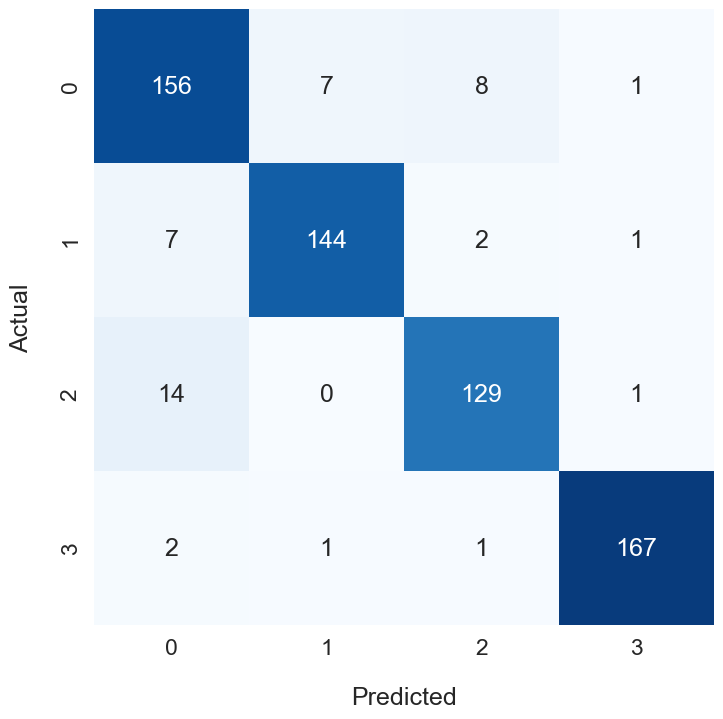

In [7]:
# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average ="weighted")
precision = precision_score(y_test, y_pred, average ="weighted")
recall = recall_score(y_test, y_pred, average ="weighted")

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1: {:.2f}%".format(f1 * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

conf_matrix = confusion_matrix(y_test, y_pred)


ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='Blues', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()